# Transparent Visualization of the Correlation between Coronavirus (COVID-19) Vaccinations and Excess Mortality in the OWID Dataset

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn import linear_model

# Get the Data

In [2]:
d=pd.read_excel('https://covid.ourworldindata.org/data/owid-covid-data.xlsx')

# Filter The Data By Countries With Both Vax and Mortality Data Present 

In [7]:
country_corr=d.groupby('iso_code')[['excess_mortality','total_vaccinations_per_hundred']].corr().unstack().iloc[:,1].reset_index()
country_corr.columns=['iso_code','correlation excess_mortality and total_vaccinations_per_hundred']
countries_worth_looking_at=list(
    country_corr[~country_corr['correlation excess_mortality and total_vaccinations_per_hundred'].isna()].sort_values(
        'correlation excess_mortality and total_vaccinations_per_hundred',ascending=False
    )['iso_code']
)
dfc = d[(d['iso_code'].isin(countries_worth_looking_at))].copy()

# Interpolate The Data By Backfilling

In [8]:
# resample needs datetime index
dfc['datetime'] = pd.to_datetime(dfc['date'])
dfc.index = dfc['datetime']
del dfc['datetime']
# we use the mean() function to fill the missing values with the NAs
dfi=dfc.groupby('iso_code').resample('W').mean().reset_index()
dfi.index = pd.to_datetime(dfi['datetime'])
del dfi['datetime']

# interpolation within countries
for i in range(len(dfi.iso_code.unique())):
    mask = dfi.loc[:,'iso_code']==dfi.iso_code.unique()[i]
    dfi[mask]=dfi[mask].interpolate(method='bfill')
dfi.reset_index(inplace=True)

# Calculate the Correlation Over the World

In [17]:
# overall correlation
for metric in ['total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
       'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',]:
    print('Correlation',metric ,'and excess_mortality = {:.3f}'.format(dfi[['excess_mortality', metric]].corr().unstack()[1])) 

Correlation total_vaccinations_per_hundred and excess_mortality = -0.039
Correlation people_vaccinated_per_hundred and excess_mortality = -0.037
Correlation people_fully_vaccinated_per_hundred and excess_mortality = -0.039
Correlation total_boosters_per_hundred and excess_mortality = -0.035


# Chart The Interpolated Data For Visuall Control Per Country

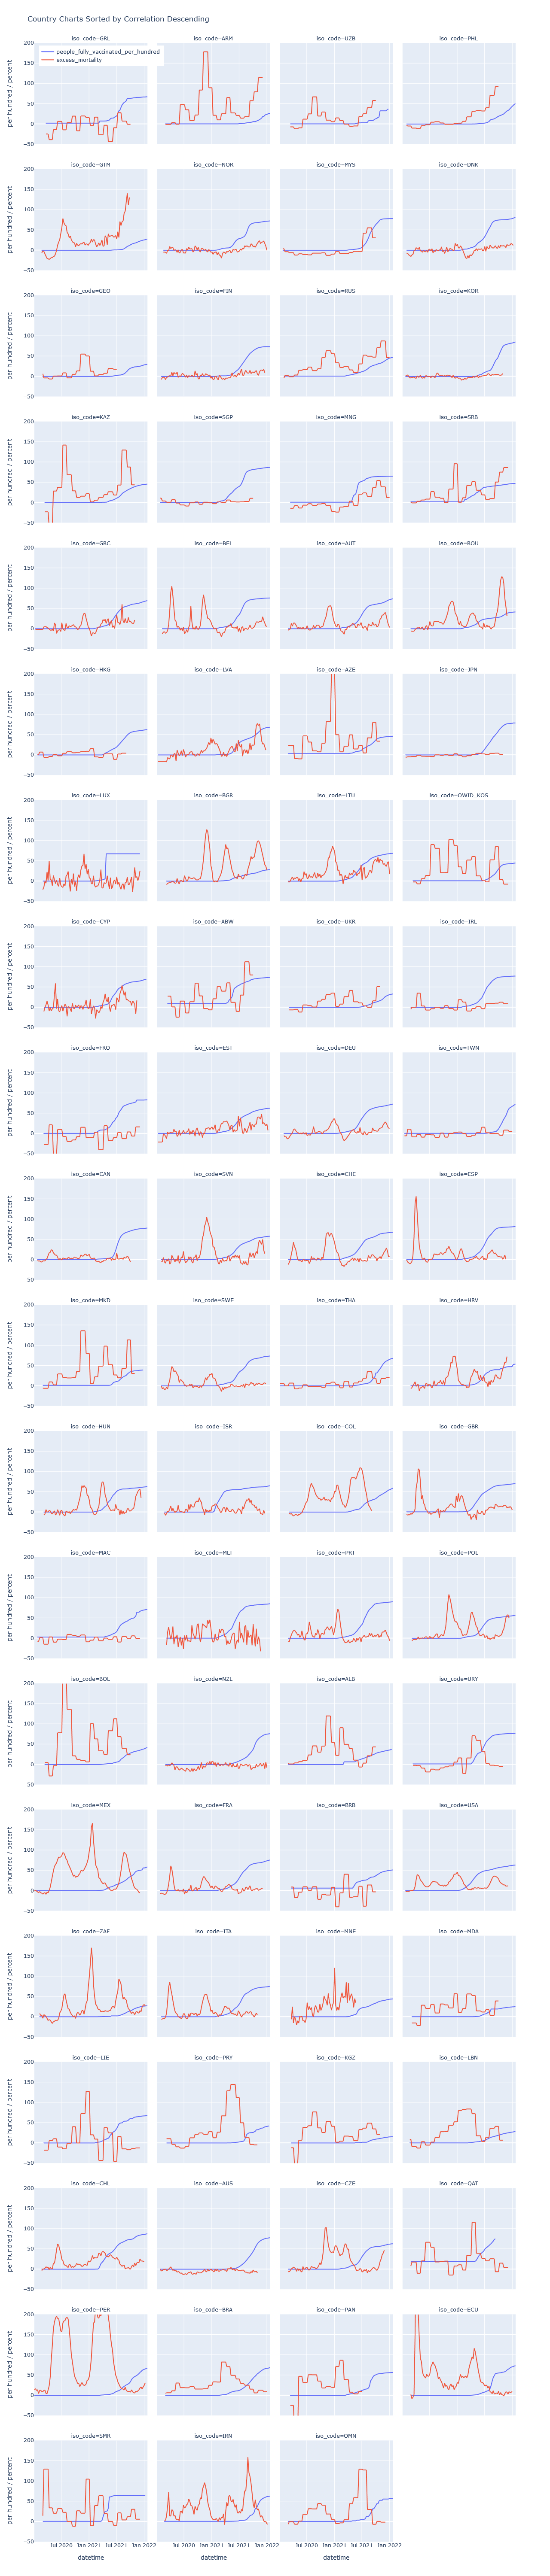

In [6]:
fig = px.line(dfi,    
              x='datetime',
              y=['people_fully_vaccinated_per_hundred','excess_mortality'],
              facet_col='iso_code', 
              category_orders={'iso_code':countries_worth_looking_at},
              facet_col_wrap=4,
              facet_row_spacing=0.01,
              height=6000, width=800,
              labels={
                  "value": "per hundred / percent",
                  "variable": "",
              },
              title="Country Charts Sorted by Correlation Descending",              
             )
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.999,
    xanchor="left",
    x=0.01
))   
fig.update_yaxes(range=[-50, 200])
fig.show() # we can't use 'png' here as the charts get scrumbled, a plotly bug?

Copyright 2021 Abbrivia GmbH https://www.abbrivia.com CC-BY (By Attribution) 4.0 https://creativecommons.org/licenses/by/4.0/legalcode
Reuse our work freely

All visualizations, and code produced in this notebook are completely open access under the Creative Commons BY license. You have the permission to use, distribute, and reproduce these in any medium, provided the source and authors are credited.

The data produced by third parties and made available by "Our World in Data" is subject to the license terms from the original third-party authors. Check the license of any third-party data before use and redistribution on 'https://ourworldindata.org/coronavirus' site (see below).

# Getting the Data

See the defintions and further discussion on the used dataset at the "Our World in Data" site  https://ourworldindata.org/covid-vaccinations

The data is taken specifically from https://covid.ourworldindata.org/data/owid-covid-data.xlsx file

Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/coronavirus' [Online Resource]

We use Excel file because it contains the data format information in itself. If you want to run this more often consider manually downloading the data and sourcing it locally as shown in the next line (commented out).